### PREPROCESSING

In [17]:
# Data manipulation
import pandas as pd
import numpy as np

# Text preprocessing
import re
import string
import nltk
from nltk.corpus import stopwords
import spacy

# Modeling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity 
from gensim import models, matutils, corpora

# Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [2]:
df = pd.read_pickle("./df_project 5.pkl")
df.head()

,index,AUTHOR,COMPOSER,DATE,LYRICS,ORCHESTRA,SINGER,TITLE,TYPE,WORDS
0,0,Julio César Curi,Edmundo Baya,1960,Tristeza... Con el vino de mi mesa Desataste u...,Rodolfo BIAGI,Hugo Duval,"[Te, burlas, tristeza]",TANGO,124
1,4,Alejandro Romay,Roberto Rufino,1959,"La casita sobre el lago azul, el nido y luz de...",Rodolfo BIAGI,Hugo Duval,"[En, el, lago, azul]",TANGO,80
2,6,Lito Bayardo,Juan de Dios Filiberto,1959,"Flor de mburucuyá, Abre tu balcón Para mi cant...",Rodolfo BIAGI,Hugo Duval,"[La, canción]",TANGO,83
3,7,Oscar Rubens,Alberto Suárez Villanueva,1945,"Tu melodía siempre la escucho, Y donde vaya, m...",Rodolfo BIAGI,Jorge Ortiz,"[Tu, melodía]",VALS,78
4,8,Alberto Vacarezza,Raúl de los Hoyos,1956,"Chiche Moro Zaino Vamos, pingos, por fav...",Rodolfo BIAGI,Hugo Duval,"[El, carrerito]",TANGO,159


In [3]:
#converting all text to lowercase
df["LYRICS"] = df["LYRICS"].str.lower()

In [4]:
#removing punctuation
df.LYRICS = df.LYRICS.map(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x))

In [5]:
#downloading spanish stopwords
nltk.download('stopwords', quiet=True)
stops = set(stopwords.words('spanish'))

In [6]:
#using spacy for lemmatization
en_core = spacy.load('es_core_news_lg')

In [7]:
df["lemmatized"] = df['LYRICS'].apply(lambda x: " ".join([y.lemma_ for y in en_core(x)]))

In [8]:
df.drop(['index'], axis=1, inplace=True)
df.head()

,AUTHOR,COMPOSER,DATE,LYRICS,ORCHESTRA,SINGER,TITLE,TYPE,WORDS,lemmatized
0,Julio César Curi,Edmundo Baya,1960,tristeza con el vino de mi mesa desataste u...,Rodolfo BIAGI,Hugo Duval,"[Te, burlas, tristeza]",TANGO,124,tristeza con el vino de mi mesa desataste ...
1,Alejandro Romay,Roberto Rufino,1959,la casita sobre el lago azul el nido y luz de...,Rodolfo BIAGI,Hugo Duval,"[En, el, lago, azul]",TANGO,80,el casita sobre el lago azul el nido y luz d...
2,Lito Bayardo,Juan de Dios Filiberto,1959,flor de mburucuyá abre tu balcón para mi cant...,Rodolfo BIAGI,Hugo Duval,"[La, canción]",TANGO,83,flor de mburucuyá abrir tu balcón para mi ca...
3,Oscar Rubens,Alberto Suárez Villanueva,1945,tu melodía siempre la escucho y donde vaya m...,Rodolfo BIAGI,Jorge Ortiz,"[Tu, melodía]",VALS,78,tu melodía siempre él escuchar y donde ir ...
4,Alberto Vacarezza,Raúl de los Hoyos,1956,chiche moro zaino vamos pingos por fav...,Rodolfo BIAGI,Hugo Duval,"[El, carrerito]",TANGO,159,chiche moro zaino ir pingo por f...


In [9]:
#tuning stopwords set
custom_stops = ['12', '13', '1910', '1e', '24telefoneá', '33', '80',
                '900cruzó', '900que', '911ya', '920', 'ser', 'ir', 'hacer', 'vo', 'haber', 'querer', 'ver', 'saber', 'tener', 'oh', 'si', 'pa', 'vos', 'aquel', 'ay',  'sos', 'así', 'bien']
stops.update(custom_stops)
#print(stops)

#removing words with lenght <3
df["lemmatized"] = df["lemmatized"].apply(lambda x: " ".join([word for word in x.split() if len(word)>2]))

In [10]:
#creating corpus
corpus = list(df["lemmatized"])

In [11]:
#Creating a document-term matrix using CountVectorizer and setting the minimum document frequency to 0.0042 and n-gram range to (1,1) for single words only (2 and 3-grams were tested but did not improve the model)
#Also setting the stop words to the previously defined custom stop words list

vectorizer = CountVectorizer(stop_words = stops,
min_df = .0042,
ngram_range = (1,1))

#Fitting and transforming the vectorizer on the lemmatized corpus
doc_term = vectorizer.fit_transform(corpus)

In [12]:
#number of topics to be extracted after empirical testing and KMeans clustering shown later in the notebook

number_of_topics = 3 

### LSA (svd)

In [141]:
#Initialize the LSA model
lsa = TruncatedSVD(number_of_topics)
#fitting LSA on the doc_term matrix
lsa.fit(doc_term)
#getting the concepts/topics
concepts = vectorizer.get_feature_names_out()
topics = lsa.components_
names = ["EMOTIONAL STRUGGLE", "TANGO LIFE", "ROMANTIC MUSIC"] # names of the topics added after analyzing the results
#SVD might produce better results as SVD results are more deterministic compared to that of NMF
#displaying the concepts and topics
for i, topic in enumerate(topics):
    print("Topic {}:".format(names[i]))
    print(" ".join([concepts[j] for j in topic.argsort()[:-10 - 1:-1]]))
    print("\n")

Topic EMOTIONAL STRUGGLE:
amor corazón vida noche poder hoy decir llorar dolor dar


Topic TANGO LIFE:
tango bailar bandoneón viejo noche barrio arrabal amigo emoción muchacho


Topic ROMANTIC MUSIC:
amor tango corazón canción voz soñar bandoneón bailar dulce flor




TRANSLATED TO ENGLISH:

Topic: EMOTIONAL STRUGGLE
love, heart, life, night, power, today, say, cry, pain, give

Topic: TANGO LIFE
tango, dance, bandoneon, old man, night, neighborhood, suburb, friend, emotion, boy

Topic: ROMANTIC MUSIC
love, tango, heart, song, voice, dream, bandoneon, dance, sweet, flower

In [142]:
""" 
Calculating cosine similarity between two documents in order to compare their similarity based on the topic distribution. The similarity score will be between 0 and 1, with 1 indicating that the documents have the same topic distribution and 0 indicating that they have completely different topic distributions.
It is not necessary to use a standard scaler in this case, as you are already using cosine similarity to compare the topic distributions of the two tangos. Cosine similarity is a measure of similarity between two non-zero vectors, and it is not affected by the scale of the vectors. Therefore, standardizing the data will not change the outcome of the similarity score.
#cosine_similarity((doc_topic[1], doc_topic[2])).round() #Testing the comparison of two songs based on their topic distribution, the idea could be to use it builing a lyric recommendation system.
"""

def find_similar_tangos(df, lsa, vectorizer, threshold=0.8): 
    """
    This function finds two similar tangos in the dataset, as long as their similarity score is above the threshold.
    
    Parameters:
    df (pandas dataframe): Dataframe containing the tango data
    lsa (TruncatedSVD model): TruncatedSVD model used for dimensionality reduction
    vectorizer (CountVectorizer): CountVectorizer used for tokenization and stop words removal
    similarity_threshold (float): 
    """
    while True:
        # Select two random tangos
        random_index_1 = np.random.randint(0, df.shape[0])
        random_index_2 = np.random.randint(0, df.shape[0])
        # Get the topic distribution for each tango
        topic_distribution_1 = lsa.transform(vectorizer.transform([df.loc[random_index_1]['lemmatized']]))
        topic_distribution_2 = lsa.transform(vectorizer.transform([df.loc[random_index_2]['lemmatized']]))
        # Calculate the cosine similarity between the two tangos
        similarity = cosine_similarity(topic_distribution_1, topic_distribution_2)[0][0]
        if similarity >= threshold:
            print("Similarity: {:.2f}%".format(similarity*100))
            print("\nTango 1:")
            print("Title: ", df.loc[random_index_1]['TITLE'])
            print("Lyrics: ", df.loc[random_index_1]['LYRICS'])
            print("\nTango 2:")
            print("Title: ", df.loc[random_index_2]['TITLE'])
            print("Lyrics: ", df.loc[random_index_2]['LYRICS'])
            break
        else:
            continue

find_similar_tangos(df, lsa, vectorizer)


Similarity: 94.39%

Tango 1:
Title:  ['Esperanza']
Lyrics:  en los dulces momentos que los dos pasamos muy juntos pienso con sentimiento mientra llora mi corazón  mi cariño es muy grande y aunque siempre niegues quererme tengo la dulce esperanza que repares tu gran traición

Tango 2:
Title:  ['Fondín', 'de', 'Pedro', 'Mendoza']
Lyrics:  fondín de pedro mendoza que sos el alma del puerto  en cada mesa las copas cuentan la historia de mi pasión  la ronca voz de un borracho le canta al alba su diana  como en aquella mañana  brumosa y fría  que te dejé   diez años son que una noche borracho de odio y de vino  quiso perderme el destino y frente a frente me la encontré  no pude más y vencido  contra esa puerta yo la maté   y desde entonces ando rodando sin fe  sin patria  sin esperanzas  cambié de nombre  cambié de cara  porque no pude no cambié el alma  y como entonces  serenamente  miro tus líneas que me fascinan  fondín del puerto  mi único amigo  sos el testigo de mi dolor   recitado  fo

In [143]:
#Use LSA to transform the doc_term matrix into a doc_topic matrix

doc_topic = lsa.transform(doc_term)

#Create a dataframe from the doc_topic matrix and round the values to 3 decimal places

doc_topic_df = pd.DataFrame(doc_topic.round(3), columns=["EMOTIONAL STRUGGLE", "TANGO LIFE", "ROMANTIC MUSIC"])

#Filter the dataframe to only show rows where the 'SWEET LOVE' topic has a value greater than 4

doc_topic_df[doc_topic_df["ROMANTIC MUSIC"] > 4]

,EMOTIONAL STRUGGLE,TANGO LIFE,ROMANTIC MUSIC
175,4.260,5.026,4.241
743,3.599,12.623,5.943
882,8.584,-1.833,5.529
1116,4.966,-0.694,4.160
1179,3.619,12.746,5.777
1334,3.358,7.483,4.455
1425,3.420,10.102,4.710


In [30]:
resultLSA = pd.merge(df, doc_topic_df, left_index=True, right_index=True)
resultLSA.head()

,AUTHOR,COMPOSER,DATE,LYRICS,ORCHESTRA,SINGER,TITLE,TYPE,WORDS,lemmatized,EMOTIONAL STRUGGLE,TANGO LIFE,ROMANTIC MUSIC
0,Julio César Curi,Edmundo Baya,1960,tristeza con el vino de mi mesa desataste u...,Rodolfo BIAGI,Hugo Duval,"[Te, burlas, tristeza]",TANGO,124,tristeza con vino mesa desataste uno pena que ...,1.834,0.414,-0.584
1,Alejandro Romay,Roberto Rufino,1959,la casita sobre el lago azul el nido y luz de...,Rodolfo BIAGI,Hugo Duval,"[En, el, lago, azul]",TANGO,80,casita sobre lago azul nido luz nuestro amor s...,2.969,-0.694,0.844
2,Lito Bayardo,Juan de Dios Filiberto,1959,flor de mburucuyá abre tu balcón para mi cant...,Rodolfo BIAGI,Hugo Duval,"[La, canción]",TANGO,83,flor mburucuyá abrir balcón para cantar luz co...,2.171,-0.003,0.762
3,Oscar Rubens,Alberto Suárez Villanueva,1945,tu melodía siempre la escucho y donde vaya m...,Rodolfo BIAGI,Jorge Ortiz,"[Tu, melodía]",VALS,78,melodía siempre escuchar donde perseguir noche...,2.908,-0.305,0.922
4,Alberto Vacarezza,Raúl de los Hoyos,1956,chiche moro zaino vamos pingos por fav...,Rodolfo BIAGI,Hugo Duval,"[El, carrerito]",TANGO,159,chiche moro zaino pingo por favor que subir re...,1.533,1.145,-0.103


In [32]:
#Another way to find similar tangos from created dataframe resultLSA

def find_similar_tangos(df):
# Setting a minimum similarity score of 0.9
    min_similarity = 0.95
    while True:
# Selecting two random tangos
        index1 = np.random.randint(0, df.shape[0])
        index2 = np.random.randint(0, df.shape[0])
# Calculating the cosine similarity of the two tangos based on their topic distributions
        similarity = cosine_similarity(df.iloc[index1, -3:].values.reshape(1, -1), df.iloc[index2, -3:].values.reshape(1, -1))
# If the similarity score is greater than or equal to 0.8
        if similarity >= min_similarity:
                # Printing the details of the two tangos
                print("Tango 1:")
                print("Title: ", df.loc[index1]['TITLE'])
                print("Lyrics: ", df.loc[index1]['LYRICS'])
                print("Topic Distribution: ", df.iloc[index1, -3:].values)
                print("\n")
                print("Tango 2:")
                print("Title: ", df.loc[index2]['TITLE'])
                print("Lyrics: ", df.loc[index2]['LYRICS'])
                print("Topic Distribution: ", df.iloc[index2, -3:].values)
                print("\n")
                print("Similarity score: ", int(similarity.item()*100), "%")
                break
        return

find_similar_tangos(resultLSA)

Tango 1:
Title:  ['Mis', 'delirios']
Lyrics:  no se puede torcer el destino como débil varilla de estaño  si al amor lo adormece un desprecio más tarde despierta  terrible  incendiario  no pretendas mujer  olvidarme ni borrar con champán el pasado  como marca indeleble yo vivo sujeto a tu vida  siguiendo tus pasos   tú pudiste cambiar el destino yo te amé con el alma y te amo  te entregué el corazón  lo rompiste tú tienes la culpa  mujer  si soy malo  y tendrás que dar cuenta al eterno de mis pobres delirios de insano  tus acciones son nobles reflejos de toda mi vida  de todos mis actos   cuando veo una flor  si es hermosa con tus dones  mi bien  la comparo  si ella es blanca  bendigo tus carnes si es roja la creo  robada a tus labios  en la estatua  en la flor  en el verso en el día  en la noche  en los astros  dondequiera que exista hermosura encuentro algo tuyo que creo sagrado   yo te tengo en mis sueños febriles si despierto te veo a mi lado  te acaricio  te nombro  te busco te mu

Analisys of the results, if topics are relevant

In [50]:
#function that prints from df the title and lyrics and the topic distribution of the song

def print_song(df, index):
    print("Title: ", df.loc[index]['TITLE'])
    print("Lyrics: ", df.loc[index]['LYRICS'])
    print("Topic Distribution: ", df.iloc[index, -3:].values)
    return

print_song(resultLSA, 2466)

Title:  ['Julian']
Lyrics:  yo tenía un amorcito que me dejó abandonada y en mis horas de tristeza lo recuerdo en el alma  era un tigre para el tango y envidia del cabaret  pero un día  traicionero  tras de otra se me fue   ¿por qué me dejaste  mi lindo julián  tu nena se muere de pena y afán    en aquel cuartito nadie más entró y paso las noches llorando tu amor   amor que fingiste hasta que caí    con besos me hiciste llorar y reír y desde aquel día  mi lindo julián  no tengo alegría  me muero de afán   nene   cómo extraño tus caricias  tus mimos y tus sonrisas  dame de nuevo tu corazón y he de pagarte contenta con mil besos de pasión  negro  yo nunca podré olvidarte    piensa que en el nido abandonado un corazón destrozado sólo puede perdonar   yo tenía un amorcito que era envidia del pigall    era un tigre para el tango y se llamaba julián    pero un día  entusiasmado por una loca ilusión  dejó el nido abandonado y destrozó mi corazón 
Topic Distribution:  [4.925 0.79 0.935]


Strong "EMOTIONAL STRUGGLE"

"I had a little love that left me abandoned and in my hours of sadness I remember it in my soul. He was a tiger for the tango and envy of the cabaret. But one day, treacherously, after another, he left me. Why did you leave me, my handsome Julian? Your girl is dying of longing and need. In that little room, no one else came in and I spent the nights crying for your love. Love that you pretended until I fell for it. With kisses you made me cry and laugh and since that day, my handsome Julian, I have no joy. I die of longing. Darling, how I miss your caresses, your cuddles and your smiles. Give me back your heart and I will pay you back happily with a thousand kisses of passion. Black, I will never be able to forget you. Think that in the abandoned nest, a broken heart can only forgive. I had a little love that was the envy of Pigalle. He was a tiger for the tango and his name was Julian. But one day, excited by a crazy illusion, he left the abandoned nest and broke my heart."

In [51]:
print_song(resultLSA, 65)

Title:  ['Canción', 'de', 'rango', "(Pa'", 'que', 'se', 'callen)']
Lyrics:  que bailen los que vienen pa’ bailar  que escuchen los que quieran escuchar  pa’ todos hay un tango acompasado  pretencioso y retobado reinando en mi ciudad  yo canto porque vivo la emoción del tango cadencioso y compadrón  yo canto cuando alguno pega el grito que hay un tango compadrito buscando un corazón   pa’ que se callen los que andan divulgando que el tango es triste  que es danza y son del fango  pa’ que se callen les voy pasando el dato  mi tango es danza triste  pero es canción de rango  pa’ que se callen les mando en dos por cuatro  esta cadencia viril que se hace canto  si son sensibles  verán que no es del fango aquel que envuelve en tangos su corazón   que bailen los que vienen pa’ bailar  que sigan escuchando los demás  hoy tengo la emoción envuelta en tango y es por eso que me agrando al son de su compás  yo canto porque vivo la emoción del tango cadencioso y compadrón  yo canto cuando alguno pe

Strong " TANGO LIFE"

"Let those who come to dance dance, let those who want to listen listen. There is a tango for everyone, pretentious and defiant, reigning in my city. I sing because I live the emotion of the cadenced and companionable tango. I sing when someone cries out that there is a tango looking for a heart. So that those who are spreading the word that the tango is sad, that it is a dance of the mud, will shut up, I'll give them the information that my tango is a sad dance, but it is a song of rank. So that they shut up, I'll send them off in two by four with this virile cadence that becomes a song. If they are sensitive, they will see that it is not of the mud that which envelops the heart in tangos. Let those who come to dance dance, let others continue listening. Today I have the emotion wrapped up in tango and that's why I grow while listening to its rhythm. I sing because I live the emotion of the cadenced and companionable tango. I sing when someone cries out that there is a tango looking for a heart."

In [70]:
print_song(resultLSA, 1398)

Title:  ['A', 'media', 'luz']
Lyrics:  corrientes 3  4  8  segundo piso  ascensor  no hay porteros ni vecinos  adentro  cocktail y amor  pisito que puso maple  piano  estera y velador  un telefón que contesta  una victrola que llora viejos tangos de mi flor y un gato de porcelana pa  que no maulle al amor   y todo a media luz  que es un brujo el amor  a media luz los besos  a media luz los dos  y todo a media luz crepúsculo interior   qué suave terciopelo la media luz de amor   juncal 12  24 telefoneá sin temor  de tarde  té con masitas  de noche  tango y cantar  los domingos  tés danzantes  los lunes  desolación  hay de todo en la casita  almohadones y divanes  come en botica  cocó  alfombras que no hacen ruido y mesa puesta al amor 
Topic Distribution:  [3.763 0.003 3.489]


Strong "ROMANTIC MUSIC"

"On the second floor of Corrientes street, number 3, 4, 8 with no doorman or neighbors. Inside, there is a cocktail and love atmosphere, with a maple floor, piano, mat, and table lamp. There is a telephone that answers and a phonograph that plays old tangos of my love and a porcelain cat so that it doesn't meow during love. Everything is in dim light, as love is a sorcerer, and kisses are in dim light, and the two of them are in dim light, a twilight inside. How soft velvet is the dim light of love. The address Juncal 12, 24, you can call without fear, in the afternoon tea with pastries, at night tango and singing. On Sundays, dancing teas, on Mondays, desolation. There is everything in the little house, pillows and sofas, you can eat at the pharmacy, cocó, carpets that don't make noise and table set for love."

### NMF

In [19]:
#initialize the NMF model
nmf = NMF(n_components=number_of_topics, init='nndsvd')
#fitting LSA on the doc_term matrix
nmf.fit(doc_term)
#getting the concepts/topics
concepts = vectorizer.get_feature_names_out()
topics = nmf.components_
names = ["EMOTIONAL STRUGGLE", "TANGO LIFE", "DREAMY LOVE"] # names of the topics added after analyzing the results
#displaying the concepts and topics
for i, topic in enumerate(topics):
    print("Topic {}:".format(names[i]))
    print(" ".join([concepts[j] for j in topic.argsort()[:-10 - 1:-1]]))
    print("\n")

Topic EMOTIONAL STRUGGLE:
vida noche decir dar volver llorar hoy poder viejo corazón


Topic TANGO LIFE:
tango bailar bandoneón corazón emoción noche arrabal voz cantar canción


Topic DREAMY LOVE:
amor corazón dolor alma vivir ilusión soñar sueño poder vida




Those topics dont seem so distinct as in LSA and the last one is diferent than in LSA ("DREAMY LOVE" vs "ROMANTIC MUSIC")

TRANSLATED TO ENGLISH:

Topic: EMOTIONAL STRUGGLE
life, night, say, surrender, return, cry, today, power, old, heart

Topic: TANGO LIFE
tango, dance, bandoneon, heart, emotion, night, suburb, voice, sing, song

Topic: DREAMY LOVE
love, heart, pain, soul, live, illusion, dream, sleep, power, life

In [86]:
#Use NMF to transform the doc_term matrix into a doc_topic matrix

doc_topic_nmf = nmf.transform(doc_term)

#Create a dataframe from the doc_topic matrix and round the values to 3 decimal places

doc_topic_df_nmf = pd.DataFrame(doc_topic_nmf.round(3), columns=["EMOTIONAL STRUGGLE", "TANGO LIFE", "DREAMY LOVE"])

#Filter the dataframe to only show rows where the 'SWEET LOVE' topic has a value greater than 4

doc_topic_df_nmf[doc_topic_df_nmf["DREAMY LOVE"] > 0.1].head()

,EMOTIONAL STRUGGLE,TANGO LIFE,DREAMY LOVE
1,0.078,0.000,0.227
2,0.046,0.056,0.160
3,0.074,0.046,0.212
5,0.048,0.002,0.332
7,0.000,0.000,0.504


In [84]:
resultNMF = pd.merge(df, doc_topic_df_nmf, left_index=True, right_index=True)
resultNMF.head()

,AUTHOR,COMPOSER,DATE,LYRICS,ORCHESTRA,SINGER,TITLE,TYPE,WORDS,lemmatized,EMOTIONAL STRUGGLE,TANGO LIFE,DREAMY LOVE
0,Julio César Curi,Edmundo Baya,1960,tristeza con el vino de mi mesa desataste u...,Rodolfo BIAGI,Hugo Duval,"[Te, burlas, tristeza]",TANGO,124,tristeza con vino mesa desataste uno pena que ...,0.151,0.030,0.030
1,Alejandro Romay,Roberto Rufino,1959,la casita sobre el lago azul el nido y luz de...,Rodolfo BIAGI,Hugo Duval,"[En, el, lago, azul]",TANGO,80,casita sobre lago azul nido luz nuestro amor s...,0.078,0.000,0.227
2,Lito Bayardo,Juan de Dios Filiberto,1959,flor de mburucuyá abre tu balcón para mi cant...,Rodolfo BIAGI,Hugo Duval,"[La, canción]",TANGO,83,flor mburucuyá abrir balcón para cantar luz co...,0.046,0.056,0.160
3,Oscar Rubens,Alberto Suárez Villanueva,1945,tu melodía siempre la escucho y donde vaya m...,Rodolfo BIAGI,Jorge Ortiz,"[Tu, melodía]",VALS,78,melodía siempre escuchar donde perseguir noche...,0.074,0.046,0.212
4,Alberto Vacarezza,Raúl de los Hoyos,1956,chiche moro zaino vamos pingos por fav...,Rodolfo BIAGI,Hugo Duval,"[El, carrerito]",TANGO,159,chiche moro zaino pingo por favor que subir re...,0.101,0.135,0.022


In [89]:
resultNMF[resultNMF["DREAMY LOVE"] > 0.7].head()

,AUTHOR,COMPOSER,DATE,LYRICS,ORCHESTRA,SINGER,TITLE,TYPE,WORDS,lemmatized,EMOTIONAL STRUGGLE,TANGO LIFE,DREAMY LOVE
882,Luis Rubistein,Juan Polito,1944,canción de amor de una serenata luna y farol c...,Francisco LOMUTO,Carlos Galarce,[Serenata],MILONGA,162,canción amor uno serenata luna farol con color...,0.000,0.135,0.848
1544,Mario César Gomila,Francisco De Caro,1933,yo te dejé por un nuevo amor porque pensé serí...,Francisco CANARO,Ernesto Fama,"[Mi, viejo, amor]",TANGO,167,dejar por uno nuevo amor porque pensar ser mej...,0.079,0.000,0.739


In [90]:
print_song(resultNMF, 882)

Title:  ['Serenata']
Lyrics:  canción de amor de una serenata luna y farol con color de plata  y un guitarrear que al brotar desata la dulce voz del payador  el cielo azul con su luna mansa volcó su luz como una esperanza  y en el balcón de malvones rojos dejó la voz esta canción   amor  amor te dejo aquí  con mi voz mi corazón   yo traigo a tus trenzas doradas mis sueños cubiertos de noche callada  amor que se viene de lejos blanqueando de luna tu boca pintada  cantando  mi bien y soñando que noche tras noche me estés esperando  por eso aquí  en tu balcón esta noche otra vez  dejaré el corazón     allí  detrás de esas margaritas un corazón de mujer palpita  un corazón que soñando espera la dulce voz del payador  amor  amor    luna con estrellas en la emoción de ilusiones bellas  ensoñación que en la noche mansa bordó en la voz esta canción   amor  amor te dejo aquí con mi voz mi corazón 
Topic Distribution:  [0.0 0.135 0.848]


Strong "DREAMY LOVE"

"Love song of a serenade moon and lantern with silver color and a guitar that when it sprouts unleashes the sweet voice of the singer. The blue sky with its gentle moon spilled its light like a hope and on the balcony of red malvones left this song. Love, love I leave you here with my voice and my heart. I bring to your golden braids my dreams covered in quiet night. Love that comes from far away whitening of the moon your painted mouth singing my love and dreaming that night after night you will be waiting for me. That's why here on your balcony tonight again I will leave my heart. There behind those daisies a woman's heart beats, a heart that dreams and waits for the sweet voice of the singer. Love, love. Moon with stars in the emotion of beautiful illusions, dream that in the gentle night embroidered in the voice of this song. Love, love I leave you here with my voice and my heart."

### LDA

In [13]:
# Transpose the document-term matrix
term_doc = doc_term.transpose()

# Convert the sparse matrix to a gensim corpus
corpusX = matutils.Sparse2Corpus(term_doc)

# Create a dictionary for the terms in the corpus
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())

# Initialize LDA model
lda = models.LdaModel(corpus=corpusX, id2word=id2word, num_topics=number_of_topics, passes=30, random_state= 44) #random_state is set to 44 to keep the same results

# Print top 10 words for each topic
for topic_id, topic in lda.print_topics(num_topics=number_of_topics, num_words=10):
    print(f'Topic {topic_id+1}: {topic}')

Topic 1: 0.016*"dar" + 0.014*"decir" + 0.011*"vida" + 0.011*"hombre" + 0.011*"hoy" + 0.010*"viejo" + 0.009*"pobre" + 0.008*"poder" + 0.007*"siempre" + 0.007*"vez"
Topic 2: 0.034*"amor" + 0.018*"corazón" + 0.016*"vida" + 0.011*"dolor" + 0.011*"poder" + 0.011*"alma" + 0.010*"llorar" + 0.009*"volver" + 0.009*"ojo" + 0.009*"noche"
Topic 3: 0.025*"tango" + 0.015*"amor" + 0.015*"corazón" + 0.015*"noche" + 0.014*"cantar" + 0.012*"viejo" + 0.009*"barrio" + 0.009*"flor" + 0.009*"canción" + 0.008*"lindo"


The are more distinct that in other models.

TRANSLATED TO ENGLISH:

Topic 1: LIFE CHOICES
give, say, life, man, today, old, poor, power, always, time

Topic 2: DRAMATIC LOVE
love, heart, life, pain, power, soul, cry, return, eye, night  

Topic 3: BARRIO MUSIC
tango, love, heart, night, singing, old, neighborhood, flower, song, beautiful

In [14]:
# Get topic labels
topic_labels = [f'Topic {i+1}' for i in range(number_of_topics)]

# Get document-topic probabilities
doc_topic_prob = [lda.get_document_topics(doc, minimum_probability=0) for doc in corpusX]

# Create dataframe with topic probabilities
doc_topic_df_lda = pd.DataFrame(doc_topic_prob, columns=["LIFE CHOICES", "DRAMATIC LOVE", "BARRIO MUSIC"])

# Merge with original dataframe
resultLDA = pd.merge(df, doc_topic_df_lda, left_index=True, right_index=True)
# From last 3 collumns extract second number as float
resultLDA['LIFE CHOICES'] = resultLDA['LIFE CHOICES'].str[1].astype(float)
resultLDA['DRAMATIC LOVE'] = resultLDA['DRAMATIC LOVE'].str[1].astype(float)
resultLDA['BARRIO MUSIC'] = resultLDA['BARRIO MUSIC'].str[1].astype(float)

resultLDA.head()

,AUTHOR,COMPOSER,DATE,LYRICS,ORCHESTRA,SINGER,TITLE,TYPE,WORDS,lemmatized,LIFE CHOICES,DRAMATIC LOVE,BARRIO MUSIC
0,Julio César Curi,Edmundo Baya,1960,tristeza con el vino de mi mesa desataste u...,Rodolfo BIAGI,Hugo Duval,"[Te, burlas, tristeza]",TANGO,124,tristeza con vino mesa desataste uno pena que ...,0.316027,0.370351,0.313622
1,Alejandro Romay,Roberto Rufino,1959,la casita sobre el lago azul el nido y luz de...,Rodolfo BIAGI,Hugo Duval,"[En, el, lago, azul]",TANGO,80,casita sobre lago azul nido luz nuestro amor s...,0.010101,0.978180,0.011719
2,Lito Bayardo,Juan de Dios Filiberto,1959,flor de mburucuyá abre tu balcón para mi cant...,Rodolfo BIAGI,Hugo Duval,"[La, canción]",TANGO,83,flor mburucuyá abrir balcón para cantar luz co...,0.014435,0.185405,0.800160
3,Oscar Rubens,Alberto Suárez Villanueva,1945,tu melodía siempre la escucho y donde vaya m...,Rodolfo BIAGI,Jorge Ortiz,"[Tu, melodía]",VALS,78,melodía siempre escuchar donde perseguir noche...,0.010551,0.532595,0.456854
4,Alberto Vacarezza,Raúl de los Hoyos,1956,chiche moro zaino vamos pingos por fav...,Rodolfo BIAGI,Hugo Duval,"[El, carrerito]",TANGO,159,chiche moro zaino pingo por favor que subir re...,0.475203,0.008658,0.516138


In [15]:
#function to print the title and lyrics of the song and the topic distribution - tests performed on the LDA model

def print_song(df, index):
    print("Title: ", df.loc[index]['TITLE'])
    print("Lyrics: ", df.loc[index]['LYRICS'])
    print("Topic Distribution: ", df.iloc[index, -3:].values)
    return
#generate random song index to test
print_song(resultLDA,np.random.randint(0, df.shape[0]))

#print_song(resultLDA, 2466)

Title:  ['Indiferencia']
Lyrics:  yo también como todos un día tenía dinero  amigos y hogar  nunca supe que había falsía  que el mundo sabía también traicionar   pero cuando a mi vida tranquila llegó la primera terrible verdad busqué apoyo en aquellos que amaba y crueles me dieron soledad   ilusión que viviendo latente pasó entre la gente y pura siguió  ilusión  hoy te busco y no estás  ilusión  no te puedo encontrar   mi pasado sucumbe aterido temblando en el frío de mi vida actual    y los años  pasando y pasando  me están reprochando porque no hice mal   si la vida pasó por tu lado dejando tronchado tu sino y tu fe  la maldad que truncó tu camino pondrá en tu destino de amores la sed   pero cuando  vencido y cansado  tu pecho agobiado requiera bondad  volverá la cabeza la gente dando indiferente soledad 
Topic Distribution:  [0.2503553628921509 0.743810772895813 0.005833855364471674]


Strong "DRAMATIC LOVE"

"Your gentle step arrived at my room, my arms open, my mouth kisses. How long have I waited for you, face to face with death, and I have defied death to see you. Lying down, I suffer, and there is no good friend beside me. What do I care about their forgetfulness, if in your hands you have brought me the best of friendship. Poor me, I seek your hand around, and it is not here. Everything is a dream, a false vision, and a mock of pain. When waking up, the loneliness of my suffering is more terrible. Who knows where you will be, and if you will remember me while I die without your goodbye. Come back to my eyes, vision that I lose, morphine and opium of memories. In my dreams deceive me with the shadow that I invoke, and so slowly take me to silence. Beloved woman, you are the past, the happy life that has returned. It is your hand here on my bed that I feel on my chest, that relieves my pain."

### WORDCLOUD

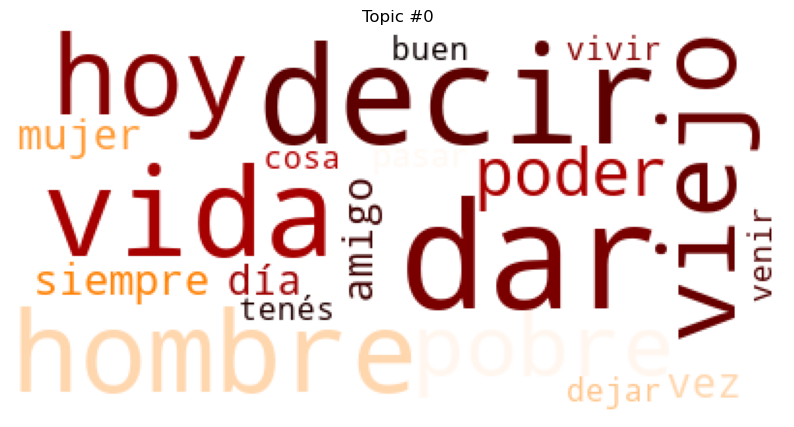

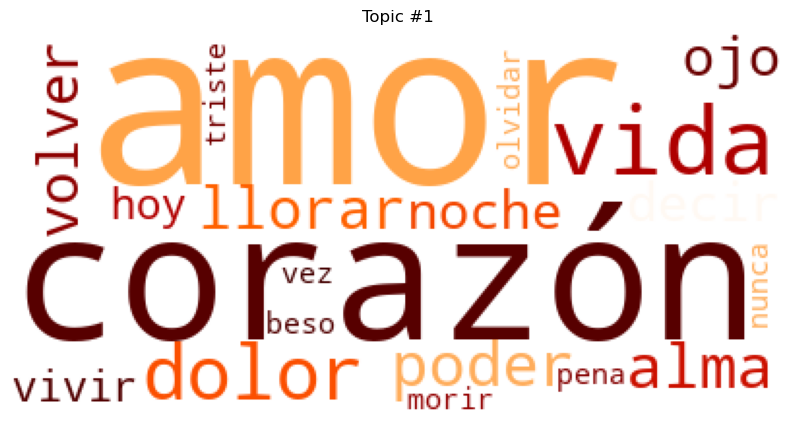

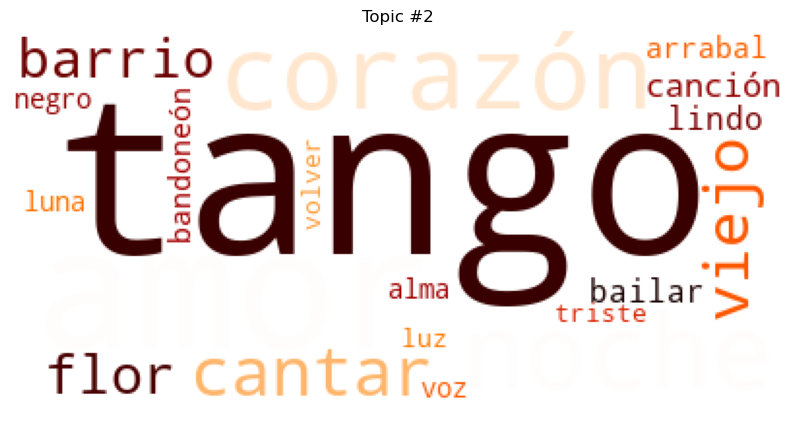

In [16]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

num_words = 20 # Number of words to include in word cloud
for t in range(lda.num_topics):
    plt.figure(figsize=(10,8))
    plt.imshow(WordCloud(background_color ='white', colormap="gist_heat_r").fit_words(dict(lda.show_topic(t, num_words))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.savefig(str(t) + ".png")

### pyLDAvis

In [23]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
#pyLDAvis for interactive visualization
#relevance metrics means how often a word appears in a topic and how often a word appears in the corpus

word2id = dict((k, v) for k, v in vectorizer.vocabulary_.items())
d = corpora.Dictionary()
d.id2token = id2word
d.token2id = word2id

vis = gensimvis.prepare(lda, corpusX, dictionary=d)
pyLDAvis.save_html(vis, 'lda_vis.html')
pyLDAvis.display(vis)


### KMEANS

In [149]:
def get_cluster_centers(X, labels, k_num):
    CC_list = []
    for k in range(k_num):
        # get the mean coordinates of each cluster
        CC_list.append(np.mean(X[labels == k], axis = 0))
    return CC_list

# for each cluster substract the mean from each data point to get the error
# then get the magnitude of each error, square it, and sum it

def get_SSE(X, labels):
    k_num = len(np.unique(labels))
    CC_list = get_cluster_centers(X, labels, k_num)
    CSEs = []
    for k in range(k_num):
        # for each cluster of k we get the coordinates of how far off each point is to the cluster
        error_cords = X[labels == k] - CC_list[k]
        # square the coordinates and sum to get the magnitude squared
        error_cords_sq = error_cords ** 2
        error_mag_sq = np.sum(error_cords_sq, axis = 1)
        # since we already have the magnitude of the error squared we can just take the sum for the cluster
        CSE = np.sum(error_mag_sq)
        CSEs.append(CSE)
    # sum each cluster's sum of squared errors
    return sum(CSEs)

    

In [151]:
km = KMeans() 
km.fit(doc_topic_df)

# get the labels
labels = km.labels_

# get the SSE
SSEs = []
Sil_coefs = []

# get the SSE for each k
for num_clusters in range(2,20):
    km = KMeans(n_clusters=num_clusters) 
    km.fit(doc_topic_df)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(doc_topic_df,labels, metric='cosine'))
    SSEs.append(get_SSE(doc_topic_df, labels)) # The SSE is just inertia, we
                                          # could have just said km.inertia_


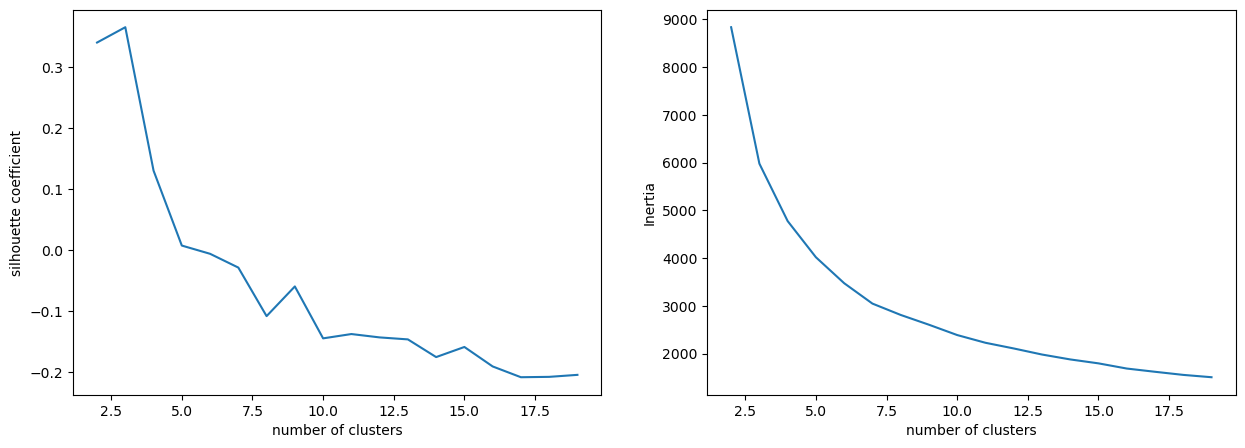

In [152]:
# number of clusters for kmeans
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(2,20)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# Sum of Square Error
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('Inertia');

Kmeans elbow method and intertia plot suggest 3 clusters as the optimal. Tests performed on diferent models and number of clusters also suggest 3 clusters.

# SENTIMENT ANALISYS

In [154]:
from sentiment_analysis_spanish import sentiment_analysis

In [104]:
sentiment = sentiment_analysis.SentimentAnalysisSpanish()
sentiment.sentiment("me gusta la tombola es genial")

0.9304396176531412

In [134]:
resultLDA['SENTIMET'] = df['lemmatized'].apply(lambda x: sentiment.sentiment(x).round(4))
resultLDA.head()

,AUTHOR,COMPOSER,DATE,LYRICS,ORCHESTRA,SINGER,TITLE,TYPE,WORDS,lemmatized,LIFE CHOICES,DRAMATIC LOVE,BARRIO MUSIC,SENTIMET
0,Julio César Curi,Edmundo Baya,1960,tristeza con el vino de mi mesa desataste u...,Rodolfo BIAGI,Hugo Duval,"[Te, burlas, tristeza]",TANGO,124,tristeza con vino mesa desataste uno pena que ...,0.316038,0.370339,0.313623,0.0000
1,Alejandro Romay,Roberto Rufino,1959,la casita sobre el lago azul el nido y luz de...,Rodolfo BIAGI,Hugo Duval,"[En, el, lago, azul]",TANGO,80,casita sobre lago azul nido luz nuestro amor s...,0.010101,0.978134,0.011765,0.0000
2,Lito Bayardo,Juan de Dios Filiberto,1959,flor de mburucuyá abre tu balcón para mi cant...,Rodolfo BIAGI,Hugo Duval,"[La, canción]",TANGO,83,flor mburucuyá abrir balcón para cantar luz co...,0.014427,0.185432,0.800141,0.0000
3,Oscar Rubens,Alberto Suárez Villanueva,1945,tu melodía siempre la escucho y donde vaya m...,Rodolfo BIAGI,Jorge Ortiz,"[Tu, melodía]",VALS,78,melodía siempre escuchar donde perseguir noche...,0.010551,0.532578,0.456871,0.0037
4,Alberto Vacarezza,Raúl de los Hoyos,1956,chiche moro zaino vamos pingos por fav...,Rodolfo BIAGI,Hugo Duval,"[El, carrerito]",TANGO,159,chiche moro zaino pingo por favor que subir re...,0.475204,0.008658,0.516139,0.0000


# EXPORT

In [ ]:
#LSA results export for Tableau
resultLDA.to_csv('project5_vis.csv')

In [545]:
#wordcloud export for Tableau - used as an ilustration fir presentation
term_doc.sum(axis = 1).reset_index().to_csv('project5_vis_cloud.csv')